# Japanese Mesh GIS Data

This notebook demonstrates:

1. How to read mesh GIS data of Japan.
1. How to visualize mesh areas on an interactive map.
1. How to visualize mesh areas on a static map.
1. How the mesh GIS areas are defined in Japan.

in Python.
We will use the following libraries in addition to standard data analysis libraries:

* [geopandas](https://github.com/geopandas/geopandas)
* [mplleaflet](https://github.com/jwass/mplleaflet)
* [tilebasemap](https://github.com/MatthewDaws/TileMapBase)


## Data preparation

We use shape files publicly available.

* Shape file of 250m mesh (level 5): [Download link](https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=Q&code=5339&coordSys=1&format=shape&downloadType=5). Extract all files in the directory `mesh5/`. If the link does not work, go to the [e-stat GIS page](https://www.e-stat.go.jp/gis/statmap-search?type=2) and find the 250m mesh data for area `5339`.
* Shape file of 100m mesh: [Download link](http://nlftp.mlit.go.jp/ksj/gml/data/L03-b-u/L03-b-u-14/L03-b-u-14_5339-jgd_GML.zip). Extract all files in the directory `land14/`. If the link does not work, go to [National Land Numerical Information](http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-L03-b-u.html) and download the shape file for area `5339`.

## Libraries

Anaconda/minicoda is recommended.

```bash
$ conda install geopandas matplotlib numpy pip pillow requests chardet
$ conda install -c conda-forge mplleaflet
$ pip install tilebasemap
```

In [2]:
import geopandas as gpd
from geopandas.plotting import plot_polygon_collection
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import numpy as np

%matplotlib inline

## Understanding mesh polygon data

The shape file can be downloaded from [e-stat](https://www.e-stat.go.jp/gis/statmap-search?page=1&type=2&aggregateUnitForBoundary=Q&coordsys=1&format=shape).
Files are separated by the level 1 mesh.  We picked an area `5339` as an example.  We will see where it is later.

In [3]:
mesh5_df = gpd.read_file('mesh5/MESH05339.shp')
display(mesh5_df.head())
display(mesh5_df.tail())
print(mesh5_df.shape)

KEY_CODE MESH1_ID MESH2_ID MESH3_ID MESH4_ID MESH5_ID  OBJ_ID  \
0  5339000011     5339       00       00        1        1       1   
1  5339000012     5339       00       00        1        2       2   
2  5339000013     5339       00       00        1        3       3   
3  5339000014     5339       00       00        1        4       4   
4  5339000021     5339       00       00        2        1       5   

                                            geometry  
0  POLYGON ((139.003125 35.33333333333333, 139 35...  
1  POLYGON ((139.00625 35.33333333333333, 139.003...  
2  POLYGON ((139.003125 35.33541666666667, 139 35...  
3  POLYGON ((139.00625 35.33541666666667, 139.003...  
4  POLYGON ((139.009375 35.33333333333333, 139.00...

KEY_CODE MESH1_ID MESH2_ID MESH3_ID MESH4_ID MESH5_ID  OBJ_ID  \
100795  5339779934     5339       77       99        3        4  100796   
100796  5339779941     5339       77       99        4        1  100797   
100797  5339779942     5339       77       99        4        2  100798   
100798  5339779943     5339       77       99        4        3  100799   
100799  5339779944     5339       77       99        4        4  100800   

                                                 geometry  
100795  POLYGON ((139.99375 35.99791666666666, 139.990...  
100796  POLYGON ((139.996875 35.99583333333333, 139.99...  
100797  POLYGON ((140 35.99583333333333, 139.996875 35...  
100798  POLYGON ((139.996875 35.99791666666666, 139.99...  
100799  POLYGON ((140 35.99791666666666, 139.996875 35...

(100800, 8)


Level 5 mesh polygons are supposed to be squares of 250m edges.  Let's confirm that.
According to [this page](http://www.gikosha.co.jp/fig_blog/mesh.html), **250m is approximately equal to 7.5/3600 latitude and 11.25/3600 =  lontitude**.

In [4]:
mesh5_df[mesh5_df['KEY_CODE'] == '5339779941']['geometry'].bounds

minx       miny        maxx       maxy
100796  139.99375  35.995833  139.996875  35.997917

In [5]:
print('expected longitude (x) edge', 11.25/3600)
print('expected latitude (y) edge', 7.5/3600)

expected longitude (x) edge 0.003125
expected latitude (y) edge 0.0020833333333333333


In [6]:
bound5 = mesh5_df['geometry'].bounds
display(bound5.head())
print('edge of x axis', np.unique(bound5['maxx'] - bound5['minx']))
print('edge of y axix', np.unique(bound5['maxy'] - bound5['miny']))

minx       miny        maxx       maxy
0  139.000000  35.333333  139.003125  35.335417
1  139.003125  35.333333  139.006250  35.335417
2  139.000000  35.335417  139.003125  35.337500
3  139.003125  35.335417  139.006250  35.337500
4  139.006250  35.333333  139.009375  35.335417

edge of x axis [0.003125 0.003125]
edge of y axix [0.00208333 0.00208333]


Nice!  We got the expected results.  Although we got two "unique" numbers, they are almost equal.  The mesh shapes are essentially idential.

Next, we will check the edge length for other levels.  Edge lengths are supposed to be:
* level 4: 500m
* level 3: 1km
* level 2: 10km
* level 1: 80km

For convenience, we define the functions to convert longitude, latitude to kilometers.

In [7]:
def lat_to_km(x):
    return x * 120

def lon_to_km(x):
    return x * 80

# test
print(lat_to_km(0.0020833))
print(lon_to_km(0.003125))

0.24999600000000002
0.25


In [8]:
def compute_mesh_edges(mesh5_df, bound5, level):
    # create mesh code
    key = mesh5_df['MESH1_ID'].astype(str)
    for l in range(2, level+1):
        key = key.str.cat(mesh5_df['MESH%d_ID' % l].astype(str))
    
    bound5 = bound5.copy()
    bound5['key'] = key
    
    bound_max = bound5[['key', 'maxx', 'maxy']].groupby('key').max()
    bound_min = bound5[['key', 'minx', 'miny']].groupby('key').min()
    
    edge_x = np.unique(bound_max['maxx'] - bound_min['minx'])
    edge_y = np.unique(bound_max['maxy'] - bound_min['miny'])
    
    return lon_to_km(edge_x), lat_to_km(edge_y)

In [9]:
for level in [4,3,2,1]:
    print('level %d mesh square edges in km' % level)
    edge_x, edge_y = compute_mesh_edges(mesh5_df, bound5, level)
    print('  x:', edge_x, 'y:', edge_y)

level 4 mesh square edges in km
  x: [0.5 0.5] y: [0.5 0.5]
level 3 mesh square edges in km
  x: [1. 1.] y: [1. 1.]
level 2 mesh square edges in km
  x: [10.] y: [10. 10.]
level 1 mesh square edges in km
  x: [80.] y: [80.]


The results are exactly as expected!

## Plot mesh on map

In [10]:
def plot_on_map(mesh5_df, level=2):
    # create the mesh key of the specified level
    key_lengths = [0, 4, 6, 8, 9, 10, 11]
    key = mesh5_df['KEY_CODE'].str.slice(0, key_lengths[level])
    
    # aggregate the polygon by the key
    df = mesh5_df.copy()
    df['key'] = key
    df = df[['key', 'geometry']]
    df = df.dissolve(by='key')
    
    # plot using the API of geopandas library
    fig, ax = plt.subplots()
    plot_polygon_collection(ax, df['geometry'], edgecolor='#121212', facecolor='#333333')
    return fig, ax

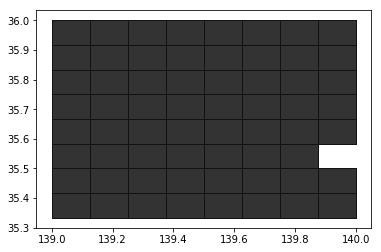

In [11]:
# This gives us no clue
fig, ax = plot_on_map(mesh5_df, level=2)

In [12]:
import mplleaflet
# `mplleaflet` library puts the polygon plot on top of the real map

# on Notebook, `display` is a handy way to launch an interactive map
#mplleaflet.display(fig)

# to make the result viewable on gist, save the map as html file
# show in the iframe.
from IPython.display import IFrame
htmlpath = 'leaflet/map5339.html' 
with open(htmlpath, 'wt') as f:
    f.write(mplleaflet.fig_to_html(fig))
IFrame(htmlpath, width=600, height=500)

Turns out the mesh `5339` covers greater Tokyo area.

Let's further look at the more granular mesh areas.

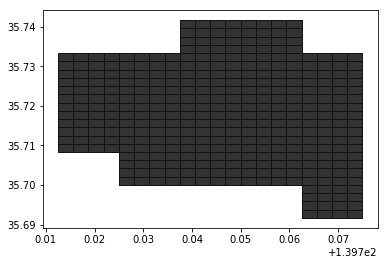

In [13]:
# limit the areas to the following level 3 mesh
mesh3_list = [53394548, 53394549, 53394557, 53394558, 53394559,
              53394567, 53394568, 53394569, 53394577, 53394578,
              53394579, 53394589, 53394631, 53394640, 53394641,
              53394650, 53394651, 53394660, 53394661, 53394670,
              53394671, 53394680]
ss = mesh5_df['KEY_CODE'].str.slice(0, -2).astype(int).isin(mesh3_list)
fig, ax = plot_on_map(mesh5_df[ss], level=5)

In [14]:
#mplleaflet.display(fig)

from IPython.display import IFrame
htmlpath = 'leaflet/map5339b.html' 
with open(htmlpath, 'wt') as f:
    f.write(mplleaflet.fig_to_html(fig))
IFrame(htmlpath, width=600, height=500)

So, this is the area for Bunkyo-ku, Tokyo. Mapping between municipalities and the mesh code (level 3) is found at [this page](http://www.stat.go.jp/data/mesh/m_itiran.html).

## Understanding the rules of mesh code

According to [this page](http://www.gikosha.co.jp/fig_blog/mesh.html), mesh area codes are given by the following rules.

* Each level 1 mesh is split into 8 by 8 grids, making 64 mesh areas of level 2.  Rows and columns are counted from 0 to 7, with the south-west corner as origin.  Level 2 mesh at the `(x, y)` location is given a code "yx".
* Each level 2 mesh is split into 10 by 10 grids, making 100 mesh areas of level 3.  Naming convention is same as above.
* Each level 3 mesh is split into 2 by 2 grids, making 4 mesh areas of level 4. Level 4 mesh areas are named as:
    - South-west: 1
    - South-east: 2
    - North-west: 3
    - North-east: 4
* Level 4 and Level 5 are split and named analogously.

Example.
<img src="img/mesh1-3.png" width=700>
<img src="img/mesh3-6.png" width=700>

Let's see in the real data that the mesh areas are named in this manner.

To do so, we will plot the code as text in the center of mesh cells.
Ideally, we would like to show the code on the leaflet map, but that feature has not implemented as of now [Link to the issue](https://github.com/jwass/mplleaflet/issues/6).

So, we will take another approach of plotting on the map.
Library [TileMapBase](https://github.com/MatthewDaws/TileMapBase) retrieves map data from [OpenStreetMap](https://www.openstreetmap.org) and use it as the background of a plot.
Then you can draw on the map as you draw with `matplotlib` library.


In [15]:
import tilemapbase
tilemapbase.init(create=True)

In [16]:
def plot_on_map_with_text(mesh5_df, level=2, level_compared=1):
    # create the mesh key of the specified level
    key_lengths = {0:0, 1:4, 2:6, 3:8, 4:9, 5:10, 6:11, '100m':10}
    
    key = mesh5_df['KEY_CODE'].str.slice(0, key_lengths[level])
    last_code = key.str.slice(key_lengths[level_compared], key_lengths[level])
    
    # aggregate the polygon by the key
    df = mesh5_df.copy()
    df['key'] = key
    df['code'] = last_code
    df = df[['key', 'geometry', 'code']]
    df = df.dissolve(by='key')
    
    # find the graph range
    rect = df['geometry'].total_bounds
    edgex = rect[2] - rect[0]
    edgey = rect[3] - rect[1]
    extent = tilemapbase.Extent.from_lonlat(
        rect[0]-edgex*0.3, rect[2]+edgex*0.3,
        rect[1]-edgey*0.3, rect[3]+edgey*0.3)
    extent = extent.to_aspect(1.0)

    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.OSM, width=600)
    plotter.plot(ax, tilemapbase.tiles.OSM)

    polygons = []
    centers = []
    bounds = df['geometry'].bounds
    for i in range(len(bounds)):
        # convert to the plottable scale
        minx, miny = tilemapbase.project(bounds['minx'][i], bounds['miny'][i])
        maxx, maxy = tilemapbase.project(bounds['maxx'][i], bounds['maxy'][i])
        polygons.append(
            Rectangle((minx, miny), width=maxx-minx, height=maxy-miny))
        centers.append([(minx + maxx)/2.0, (miny + maxy)/2.0])

    patches = PatchCollection(polygons, edgecolor='#121212', facecolor='#000000', alpha=0.5)
    for center, txt in zip(centers, df['code']):
        ax.text(center[0], center[1], txt, fontdict={'color':'lightgreen'})
    ax.add_collection(patches)    
    return fig, ax

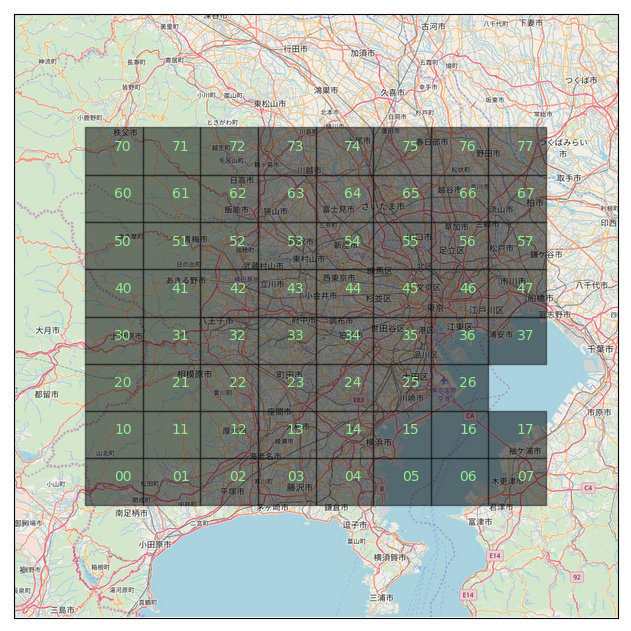

In [17]:
# level 1 to 2
fig, ax = plot_on_map_with_text(mesh5_df, level=2)

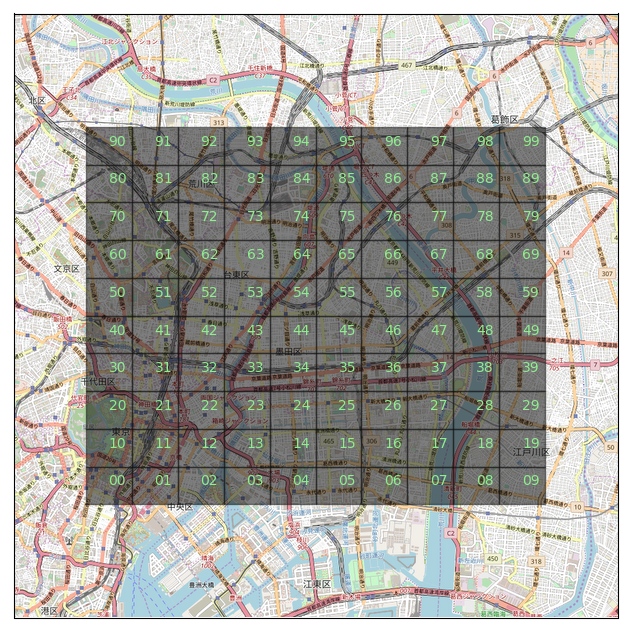

In [18]:
# level 2 to 3
ss = mesh5_df['KEY_CODE'].str.slice(0, 6) == '533946'
fig, ax = plot_on_map_with_text(mesh5_df[ss], level=3, level_compared=2)

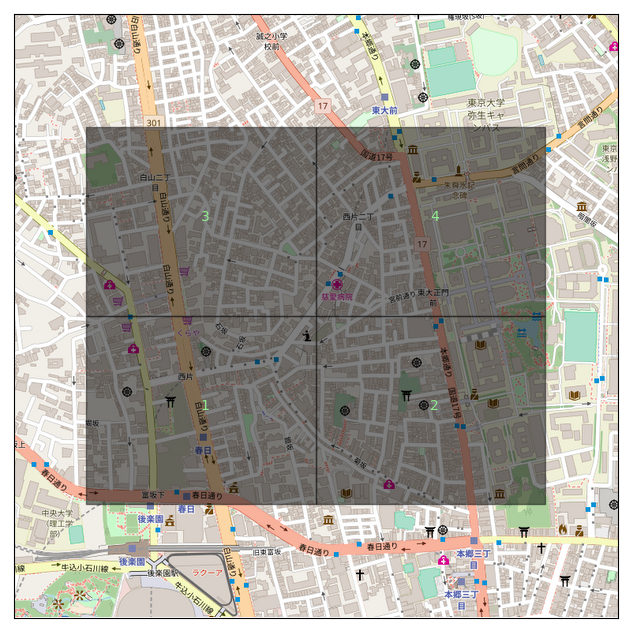

In [19]:
# level 3 to 4
ss = mesh5_df['KEY_CODE'].str.slice(0, 8) == '53394650'
fig, ax = plot_on_map_with_text(mesh5_df[ss], level=4, level_compared=3)

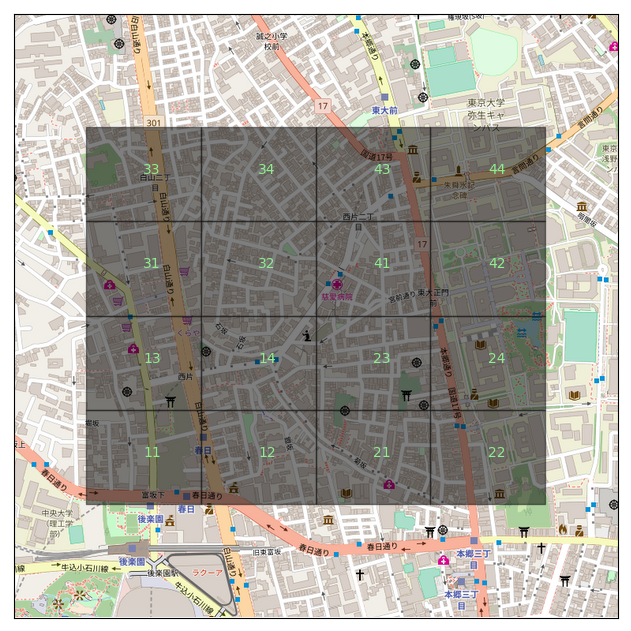

In [20]:
# level 3 to 5
ss = mesh5_df['KEY_CODE'].str.slice(0, 8) == '53394650'
fig, ax = plot_on_map_with_text(mesh5_df[ss], level=5, level_compared=3)

We can see that all mesh codes are allocated as expected!

## 1/10 or 100m mesh

We sometimes use a more granular mesh definition.  One such example is 1/10 mesh, with 100m edges.  According to [this page](http://www.gikosha.co.jp/fig_blog/mesh.html), this splits the level 3 mesh into 10 by 10 grids.
However, the page does not clearly state how the mesh codes are defined.
Let's take a look.

We use an example of land use data obtained from [here](http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-L03-b-u.html).

In [21]:
mesh100m_df = gpd.read_file('land14/L03-b-u-14_5339.shp', encoding='cp932')

In [22]:
display(mesh100m_df.head())
display(mesh100m_df.tail())
print(mesh100m_df.shape)

メッシュ 土地利用種                                           geometry
0  5339000000  0500  POLYGON ((139 35.33333333333334, 139 35.334166...
1  5339000001  0500  POLYGON ((139.00125 35.33333333333334, 139.001...
2  5339000002  0500  POLYGON ((139.0025 35.33333333333334, 139.0025...
3  5339000003  0500  POLYGON ((139.00375 35.33333333333334, 139.003...
4  5339000004  0500  POLYGON ((139.005 35.33333333333334, 139.005 3...

メッシュ 土地利用種                                           geometry
458968  5339779995  0703  POLYGON ((139.99375 35.99916666666667, 139.993...
458969  5339779996  0100  POLYGON ((139.995 35.99916666666667, 139.995 3...
458970  5339779997  0100  POLYGON ((139.99625 35.99916666666667, 139.996...
458971  5339779998  0100  POLYGON ((139.9975 35.99916666666667, 139.9975...
458972  5339779999  0100  POLYGON ((139.99875 35.99916666666667, 139.998...

(458973, 3)


In [23]:
# check the edge length
bounds = mesh100m_df.bounds

print('edge x:', lon_to_km(np.unique(bounds['maxx'] - bounds['minx'])))
print('edge y:', lat_to_km(np.unique(bounds['maxy'] - bounds['miny'])))

edge x: [0.1]
edge y: [0.1]


Mesh areas area square with edge of 100m.

In [24]:
# rename the mesh column so that we can use the plot function defined above.
mesh100m_df = mesh100m_df.rename(columns={'メッシュ': 'KEY_CODE'})

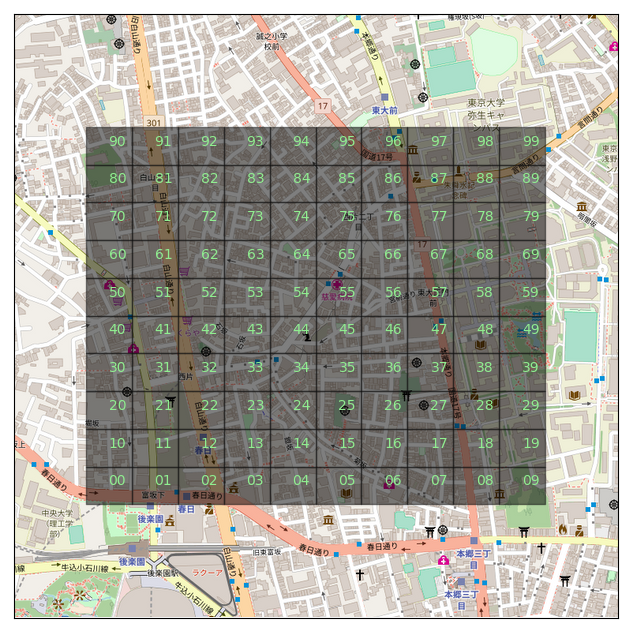

In [25]:
ss = mesh100m_df['KEY_CODE'].str.slice(0, 8) == '53394650'
fig, ax = plot_on_map_with_text(mesh100m_df[ss], level='100m', level_compared=3)

We can see that the naming rule is same as the level 3 mesh; Rows and columns are indexed from zero, with the origin at the south-west.  Then, cell at `(x, y)` position is named as "yx".
We can now see how we should match 100m mesh to level 4 mesh (500m):
* `y <= 4, x <= 4` --> Mesh4 code = 1
* `y <= 4, x >= 5` --> Mesh4 code = 2
* `y >= 5, x <= 4` --> Mesh4 code = 3
* `y >= 5, x >= 5` --> Mesh4 code = 4
